In [ ]:
"""
This notebook has flextok related code.

1) sanity check that the saved register tokens are correct by using them for reconstruction.
"""

In [1]:
# add the parent directory to the Python path
import sys
import os
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
print(sys.path)
from data.utils.dataloaders import get_imagenet_dataloader
import numpy as np
import torch
from flextok.flextok_wrapper import FlexTokFromHub
from flextok.utils.misc import detect_bf16_support, get_bf16_context, get_generator
from flextok.utils.demo import imgs_from_urls, denormalize, batch_to_pil

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import time

# Detect if bf16 is enabled or not
enable_bf16 = detect_bf16_support()
print('BF16 enabled:', enable_bf16)

['/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python311.zip', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/lib-dynload', '', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages', '/BS/data_mani_compress/work/thesis/thesis/external/guided-diffusion', '/BS/data_mani_compress/work/thesis/thesis/external/DenseFlow', '/BS/data_mani_compress/work/thesis/thesis']


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BF16 enabled: True


In [2]:
# Load a FlexTok d18-d28 model trained on DFN from HuggingFace Hub
flextok = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d18_in1k').to(device).eval()

In [3]:
# read the register tokens from the .npz file
register_tokens_npz = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagnet_register_tokens/imagnet_train_register_tokens.npz"
data = np.load(register_tokens_npz)
register_tokens = data['token_ids']

In [4]:
start = time.time()
with get_bf16_context(enable_bf16):
    reconst = flextok.detokenize(
        [torch.tensor(register_tokens[0]).unsqueeze(0).to(device)],
        timesteps=25, # Number of denoising steps
        guidance_scale=7.5, # Classifier-free guidance scale
        perform_norm_guidance=True, # APG, see https://arxiv.org/abs/2410.02416
         # Optionally control initial noise. Note that while the initial noise is deterministic, the rest of the model isn't.
        generator=get_generator(seed=0, device=device),
        verbose=False, # Enable to show denoising progress bar with tqdm
    )
end = time.time()

print(f"Elapsed time: {end - start:.4f} seconds")

Elapsed time: 7.0837 seconds


In [7]:
imagenet = get_imagenet_dataloader(split="train")

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
imgs = imgs_from_urls([
    f'https://storage.googleapis.com/flextok_site/nb_demo_images/{i}.png' 
    for i in range(6)
]).to(device)

In [19]:
print(imgs[0].shape)
# print min and max of imgs[0]
print(imgs[0].min().item(), imgs[0].max().item())

torch.Size([3, 256, 256])
-1.0 0.9529411792755127


In [ ]:
print(type(reconst))
batch_to_pil(reconst)

In [16]:
# show range of pixel values
print(reconst.min().item(), reconst.max().item())
print(imagenet.dataset[0][0].min().item(), imagenet.dataset[0][0].max().item())
# find the mean and std of the reconstructed image
print(reconst.mean().item(), reconst.std().item())
print(imagenet.dataset[0][0].mean().item(), imagenet.dataset[0][0].std().item())

-1.0743646621704102 1.0367029905319214
-2.1179039478302 2.640000104904175
-0.02385372668504715 0.6918564438819885
0.12438247352838516 1.510769248008728


In [22]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
def denormalize_imagenet(tensor):
    """Denormalizes a tensor normalized with ImageNet statistics."""
    mean = torch.tensor(IMAGENET_MEAN).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(IMAGENET_STD).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

img_original = denormalize_imagenet(imagenet.dataset[0][0].unsqueeze(0).to(device))
img_vae_input = img_original * 2 - 1                   # now in [-1,1]


In [23]:
# find min and max of img_original
print(img_vae_input.min().item(), img_vae_input.max().item())

-1.0 1.0


In [ ]:
import lpips
loss_fn = lpips.LPIPS(net='vgg').to(device).eval()


In [24]:

print(reconst.shape)
print(imagenet.dataset[0][0].shape)
loss_fn(reconst, img_vae_input.to(device))

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


tensor([[[[0.2445]]]], device='cuda:0', grad_fn=<AddBackward0>)

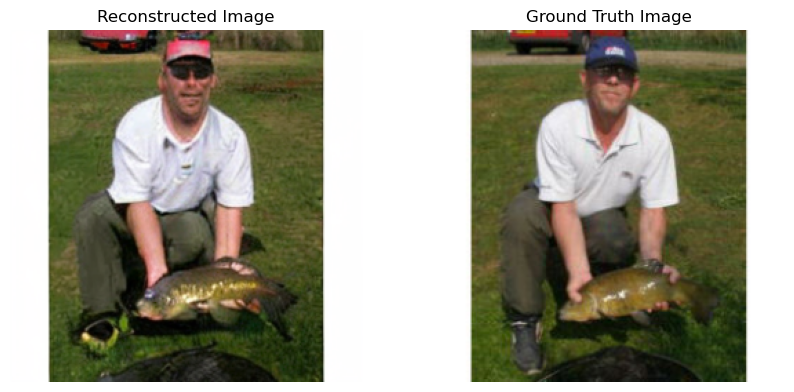

: 

In [ ]:
# show both images side by side
from PIL import Image
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(batch_to_pil(reconst))
axs[0].set_title("Reconstructed Image")
axs[0].axis("off")
axs[1].imshow(batch_to_pil(img_vae_input.to(device)))
axs[1].set_title("Ground Truth Image")
axs[1].axis("off")
plt.show()  